# Init

## Utils

In [1]:
from contentScoreShareUtils import * 

# Data

## Load Data

### elo.contact (mcvisid_elqid_email)
- conclusion
    - every elqid should have a matched email. 
    - every elqid is corresponding with one Form. So, one visitor can have multiple elqid
    - not all the email can be found on CRM.Lead table
    - <font color=red>if shared EloquaContactId or EmailAddress = aggregate as one User (not handle yet)</font>
- Latest one month
    - <font color=red>all mcvisid in mcvisid_elqid_email are the positive signal: </font>
    - all other mcvisid not in mcvisid_elqid_email but in aem_raw is the negative signal: 
    
- mcvisid_elqid_email_all: no time range selection

<!-- WITH TMP1 AS (
SELECT DISTINCT [EloquaContactId], [mcvisid]
FROM [Staging].[aem].[RawTraffic]
WHERE EloquaContactId <> ''
), 

TMP2 AS (
SELECT DISTINCT  TMP1.[mcvisid], elq.EloquaContactId, LOWER(elq.[EmailAddress]) AS "EmailAddress"
FROM [Staging].[elq].[Contact] AS elq
INNER JOIN TMP1 ON TMP1.EloquaContactId = elq.EloquaContactId
WHERE elq.EloquaContactId <> ''
)

SELECT *
FROM TMP2 -->

- mcvisid_elqid_email_all: VisitStartDateTime > '2022-04-21'


<!-- WITH TMP1 AS (
SELECT DISTINCT [EloquaContactId], [mcvisid]
FROM [Staging].[aem].[RawTraffic]
WHERE EloquaContactId <> '' AND VisitStartDateTime > '2022-04-21'
), 

TMP2 AS (
SELECT DISTINCT  TMP1.[mcvisid], elq.EloquaContactId, LOWER(elq.[EmailAddress]) AS "EmailAddress"
FROM [Staging].[elq].[Contact] AS elq
INNER JOIN TMP1 ON TMP1.EloquaContactId = elq.EloquaContactId
WHERE elq.EloquaContactId <> ''
)

SELECT *
FROM TMP2 -->

In [2]:
email_mcvisid = pd.read_csv("mcvisid_elqid_email_all.csv")
email_mcvisid, drop_mcvisid = email_cleanup(email_mcvisid, "EmailAddress")

#### positive label 1
- if can find the elq contact ID, then treated as positive

In [ ]:
positive_mcvisid = email_mcvisid["mcvisid"].drop_duplicates() ## all along the past, if mcvisid existed with corresponding elqid, then it is positive sigal

### crm Lead
- unique EloquaContactId -> do some update on this table for the same ID
- statuscodename: 
        ['New', 'Does not meet campaign criteria', 'Duplicate Lead', 'Already Active Opportunity', 'Insufficient information to contact', 'No buying intention', 'Not Decision Maker', 'Not buying or influence location', 'No Interest', 'Qualified', 'Unable to make contact (via phone,email)', 'No viable contact', 'Max Attempts', 'Unable to make contact', 'No RA solution', 'Assigned to Distribution', 'Bad Contact Information', 'Admin Only: Abandoned by Sales', 'Selling barrier to high', 'Not Buying Location', 'Unable to Process', 'Competitor/Non RA distributor', nan, 'Credit hold or watch', 'External Processing']
- statecodename: 
        ['Open', 'Disqualified', 'Qualified', nan]
- ra_generalengagementscore: 
        ['B4', nan, 'D4', 'A4', 'B1', 'B2', 'A2', 'D1', 'A1', 'A3', 'C2', 'C1', 'C4', 'B3', 'C3', 'D3', 'D2', '953810003.0']
- ra_salesacceptedname: 
        [nan, 'Yes', 'No']


In [210]:
_lead = pd.read_csv("crm_Lead_20221116_all.csv", index_col=0)
crm_lead, drop_rows = email_cleanup(_lead, "emailaddress1")

In [262]:
statecodename_positive_rules = {"Qualified": 1}
statuscodename_positive_rules = {"Already Active Opportunity": 1, "Assigned to Distribution":1}
crm_lead["statecode_signal"] = crm_lead["statecodename"].map(statecodename_positive_rules).fillna(0)
crm_lead["statuscode_signal"] = crm_lead["statuscodename"].map(statuscodename_positive_rules).fillna(0)

def label_assign_rules(x):
    target_cols = x[["statuscode_signal", "statecode_signal"]]
    is_positive = target_cols.sum().sum()>0 # one of them is positive
    return is_positive

x = crm_lead[crm_lead["emailaddress1"] == "idy1983@163.com"]
x.to_excel("sample_lead-1.xlsx")

email_updated_label = crm_lead.groupby("emailaddress1").apply(lambda x: label_assign_rules(x))
email_updated_label = email_updated_label.reset_index()
email_updated_label.columns = ["EmailAddress", "label"]

#### positive label 2
- if can find the elq contact ID, and rules are satisfied in CRM table, then treated as positive 
- rules diagram: https://app.diagrams.net/#G1cZkJWofiA_C-lV5Iqe0PBud0n3IuZVuT

In [291]:
print(email_updated_label["label"].value_counts())
email_updated_label.sample(10)

False    101227
True      33925
Name: label, dtype: int64


,EmailAddress,label
83271,matt.gidley@pcmc.com,False
76425,linda@wizcad.co.za,True
125963,tommy.w.byerly@clarios.com,False
25508,compras@prodismo.com,True
71195,kerry.sacilotto@riotinto.com,False
68914,jyarcia@mondelez.com,False
63921,john.koester@spsx.com,False
35523,dsouweine@fitchcompany.com,False
80582,marcelo.araujo@crwautomacao.com.br,True
130694,wanghaiying7@portqhd.com,True


In [325]:
mcvisid_labels = email_mcvisid.merge(email_updated_label, on="EmailAddress", how="left")
mcvisid_labels["label"].fillna(False, inplace=True)
positive_mcvisid = mcvisid_labels[mcvisid_labels["label"] == True]["mcvisid"]
updated_labels = mcvisid_labels[["mcvisid","label"]].drop_duplicates()

#### correlation analysis

### AEM.raw 
```python
'SessionVisitorId', 'VisitPageNumber', 'VisitNumber', 'NewVisit',
'EventList', 'DateTime_UTC', 'PageURL', 'VisitReferrer',
'VisitReferrerType', 'VisitorDomain', 'External_Audience',
'External_AudienceSegment', 'External_Industry', 'External_Website',
'EloquaContactId', 'EloquaGUID', 'mcvisid', 'GeoCity', 'GeoCountry',
'GeoRegion', 'PDFurl', 'PDFpagecount', 'BingeId', 'BingeCriticalScore',
'BingeScoredAssetPath', 'BingeScoredAssetScore', 'date', 'hour',
'clean_PageURL', 'label'
```

In [4]:
usecols = [
    "mcvisid", "clean_PageURL", "label", "PDFurl", "BingeScoredAssetPath", "BingeId", "date", "hour",
    "VisitReferrer", "VisitorDomain", 'External_Audience',
    'External_AudienceSegment', 'External_Industry', 'External_Website',
    "EloquaContactId", "PageURL"
]

In [5]:
# aem_raw = load_csv_batches(glob_pattern="./aem_raw/*.csv", num=2, keep="last") 
aem_raw = pd.read_csv("stage1_raw_v1.1.csv", nrows=None, usecols=usecols)

In [6]:
view3 = aem_raw.groupby("clean_PageURL")["mcvisid"].count().rename("page_visit_count").to_frame()
view3.sort_values(by="page_visit_count")

,page_visit_count
clean_PageURL,
https://www.rockwellautomation.com/products/details.440T-MSTUE110B,1
https://www.rockwellautomation.com/products/details.800A-C2CC4LC,1
https://www.rockwellautomation.com/products/details.800A-C2CC2L,1
https://www.rockwellautomation.com/products/details.800A-C2CC24C,1
https://www.rockwellautomation.com/products/details.800A-C2CC24,1
...,...
https://www.rockwellautomation.com/support,232691
https://www.rockwellautomation.com/products/hardware/allen-bradley,677975
https://www.rockwellautomation.com/en-us,1347109


In [331]:
view3[view3["page_visit_count"]>100000].sort_values("page_visit_count")

,page_visit_count
clean_PageURL,
https://www.rockwellautomation.com/company/events/in-person-events/automation-fair,108723
https://www.rockwellautomation.com/products/software/factorytalk,116044
https://www.rockwellautomation.com/sales,124975
https://www.rockwellautomation.com/products/hardware/allen-bradley/programmable-controllers,135873
https://www.rockwellautomation.com,139829
https://www.rockwellautomation.com/support/product/product-compatibility-migration/product-lifecycle-status,155410
https://www.rockwellautomation.com/support/documentation/literature-library,155754
https://www.rockwellautomation.com/products,156632
https://www.rockwellautomation.com/company/about-us,165237


In [332]:
view4 = view3[(view3["page_visit_count"]>10) & (view3["page_visit_count"]<100000)]
view4["page_visit_count"].describe()

count   19590.00000
mean      373.29632
std      2393.07215
min        11.00000
25%        17.00000
50%        33.00000
75%       101.00000
max     87730.00000
Name: page_visit_count, dtype: float64

In [ ]:
stage1_raw = aem_raw.drop(columns=["label"]).merge(updated_labels, on="mcvisid", how="left")
print(stage1_raw["label"].fillna("nan").value_counts())
# stage1_raw["label"] = stage1_raw["label"].fillna(False)
stage1_raw.dropna(subset=["label"])
print(stage1_raw["label"].fillna("nan").value_counts())

## Summary
positive_mcvisid is all the valid mcvisid that has elqID in AEM Raw

### unique version

In [338]:
aem_raw_unique_mcvisid = stage1_raw["mcvisid"].drop_duplicates()
labels = aem_raw_unique_mcvisid.isin(positive_mcvisid)
freq = labels.value_counts()
view_mcvisid = pd.concat([freq,freq/freq.sum()], axis=1)
view_mcvisid

,mcvisid,mcvisid
False,5357728,0.99872
True,6881,0.00128


### non-unique version

In [339]:
labels = stage1_raw["mcvisid"].isin(positive_mcvisid)
freq = labels.value_counts()
view_mcvisid = pd.concat([freq,freq/freq.sum()], axis=1)
view_mcvisid

,mcvisid,mcvisid
False,14538095,0.98557
True,212834,0.01443


### page conversion ratio

In [340]:
total = stage1_raw.groupby("clean_PageURL").size().rename("total")
pos = stage1_raw.groupby("clean_PageURL")["label"].sum().rename("positive")
aa = pd.concat([total, pos], axis=1)
aa["ratio"] = aa["positive"]/aa["total"]
aa["negative"] = aa["total"] - aa["positive"]

In [342]:
aa[(aa["total"]>100) & (aa["ratio"]>0.05)].sort_values("ratio")

,total,positive,ratio,negative
clean_PageURL,,,,
https://www.rockwellautomation.com/company/news/presentations/totalforce-technology-video,139,7,0.05036,132
https://www.rockwellautomation.com/company/events/webinars/achieving-sustainability-goals-through-digital-technologies,296,15,0.05068,281
https://www.rockwellautomation.com/company/events/webinars/cip-security,531,27,0.05085,504
https://www.rockwellautomation.com/support/documentation/technical-data/functionalsafetydocum20180905-1614,3433,175,0.05098,3258
https://www.rockwellautomation.com/products/software/factorytalk/designhub/optix,1248,64,0.05128,1184
...,...,...,...,...
https://www.rockwellautomation.com/nl-be,585,86,0.14701,499
https://www.rockwellautomation.com/fr-be,633,96,0.15166,537
https://www.rockwellautomation.com/company/events/in-person-events/roklive-2022-sydney---get-inspired-to-innovate-/recommended-accommodation,150,25,0.16667,125


#### regex checking with missing url

In [343]:
result_list = """|/company/news/presentations/event_materials_page.html                                                                       |   125 |    125 |    0 | 1.0000 |
|/company/news/magazines/beat-the-heat-when-mounting-low-voltage-ac-drives.html                                              |   106 |    100 |    0 | 0.9434 |
|/company/events/in-person-events/partnernetwork-conf-kr.html                                                                |   155 |    129 |    0 | 0.8323 |
|/company/events/webinars/functional-safety-techconnect.html                                                                 |   103 |     80 |    0 | 0.7767 |
|/company/events/in-person-events/archive.html                                                                               |   146 |    113 |    0 | 0.7740 |
|/company/events/webinars/webinaire-process-dcs-plantpax.html                                                                |   148 |    113 |    0 | 0.7635 |
|/company/events/webinars/modernising-to-smart-connected-systems.html                                                        |   163 |    124 |    0 | 0.7607 |
|/campaigns/thank-you-smart-downloads.html                                                                                   |   129 |     98 |    0 | 0.7597 |
|/company/events/webinars/product-registration.html                                                                          |   218 |    163 |    0 | 0.7477 |
|/campaigns/emea/en/company/events/webinars/tech-talks/hms-claroty-stratus.html                                              |   202 |    151 |    0 | 0.7475 |
|/company/events/webinars/techconnect-genius-webinar--subscription-portal-overview-session2.html                             |  1447 |   1057 |    0 | 0.7305 |
|/company/events/webinars/404.html                                                                                           |   151 |    109 |    0 | 0.7219 |
|/campaigns/emea/en/company/events/webinars/technical-competency-updates/unleash-the-new-capabilities-of-edge-analytics.html |   372 |    266 |    0 | 0.7151 |
|/en-mde/products/hardware/allen-bradley/drives.html                                                                         |   101 |     72 |    0 | 0.7129 |
|/support/product/product-selection-configuration/global-short-circuit-current-ratings-tool.html                             |  7015 |   4995 |    0 | 0.7120 |
|/company/events/in-person-events/partnernetwork-conference.html                                                             |   245 |    174 |    0 | 0.7102 |
|/industries/chemical/vfd-energy-savings-calculator.html                                                                     |   215 |    152 |    0 | 0.7070 |
|/company/news/column/executive_news_japan.html                                                                              |   112 |     79 |    0 | 0.7054 |
|/en-mde/support/product/product-compatibility-migration/product-lifecycle-status.html                                       |   280 |    196 |    0 | 0.7000 |
|/campaigns/emea/en/company/events/webinars/tech-talks/cisco-prosoft-spectrum-controls.html                                  |   120 |     84 |    0 | 0.7000 |
|/company/events/webinars/micro-control-integrated-automation-solution.html                                                  |   280 |    194 |    0 | 0.6929 |
|/company/events/webinars/protect-your-gigafactory-with-industrial-security.html                                             |   169 |    116 |    0 | 0.6864 |
|/support/documentation/technical-data/proposalworkssuppleme20180213-1403.html                                               |   114 |     78 |    0 | 0.6842 |
|/company/events/webinars/technology-partner-genius-webinar-with-prosoft-technology---conn.html                              |   114 |     78 |    0 | 0.6842 |
|/support/documentation/technical-data/proposalworksaddinghe20180213-1349.html                                               |   104 |     71 |    0 | 0.6827 |
|/company/events/in-person-events/roklive/emea/faq.html                                                                      |   321 |    219 |    0 | 0.6822 |
|/company/events/webinars/technology-partner-genius-webinar-with-oden-technologies.html                                      |   796 |    542 |    0 | 0.6809 |
|/company/news/blogs/single-use-system-lifesciences-pt2.html                                                                 |   102 |     69 |    0 | 0.6765 |
|/company/news/demonstrations/safety-automation-builder-software-demonstration.html                                          |   307 |    207 |    0 | 0.6743 |
|/company/news/blogs/from-automation-to-autonomy.html                                                                        |   153 |    103 |    0 | 0.6732 |"""

In [344]:
xx = "detail"
result_check = pd.DataFrame([[item.strip() for item in row.split("|") if len(item)>1 ]for row in result_list.split("\n") ], columns=["clean_PageURL", "total", "eloqua","crm", "ratio"])
# stage1_raw[stage1_raw["PageURL"].str.contains(xx)][["clean_PageURL", "PageURL"]].drop_duplicates().head(50).style
clean_urls = stage1_raw["clean_PageURL"].drop_duplicates()
all_urls = stage1_raw["PageURL"].drop_duplicates()
for row in result_check["clean_PageURL"].tolist():
    a = clean_urls.str.contains(xx).any()
    b = all_urls.str.contains(xx).any()
    if a is False or b is False:
        print(row)
        
result_check["clean_PageURL"] = result_check["clean_PageURL"].apply(lambda x: "https://www.rockwellautomation.com" + x[:-5])
# result_check.style

In [345]:
ss = aem_raw[aem_raw["PageURL"].str.contains("beat-the-heat-when-mounting-low-voltage-ac-drives")]

In [346]:
result_wei = aa.reset_index().sort_values(by="ratio")
result_wei.describe()
# result_wei[(result_wei["total"]>50) & (result_wei["ratio"]>0.05)].tail(50)

,total,positive,ratio,negative
count,462480.00000,462480.00000,462480.00000,462480.00000
mean,31.89528,0.42304,0.00143,31.47224
std,4071.00327,55.97115,0.02236,4023.01308
min,1.00000,0.00000,0.00000,0.00000
25%,1.00000,0.00000,0.00000,1.00000
50%,1.00000,0.00000,0.00000,1.00000
75%,1.00000,0.00000,0.00000,1.00000
max,1741369.00000,27200.00000,1.00000,1714169.00000


In [347]:
plot_data = result_wei.query("10000>`total`>50 and `ratio`>0.05")
plot_data.describe()

,total,positive,ratio,negative
count,190.00000,190.00000,190.00000,190.00000
mean,451.96842,36.20000,0.07862,415.76842
std,961.62834,79.63915,0.04522,884.48943
min,51.00000,3.00000,0.05036,38.00000
25%,64.00000,4.00000,0.05556,59.00000
50%,94.00000,7.50000,0.06452,87.00000
75%,294.00000,22.75000,0.08502,279.00000
max,7560.00000,621.00000,0.40217,6939.00000


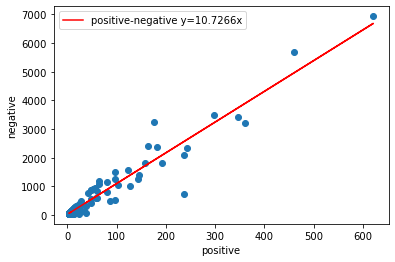

In [380]:
from sklearn.linear_model import LinearRegression
# [(result_wei["freq"]>50)  & (result_wei["ratio"]>0.05)]
x = plot_data["positive"].values.reshape(-1,1)
y = plot_data["negative"].values.reshape(-1,1)
linear_regressor = LinearRegression()
linear_regressor.fit(x, y)
y_pred = linear_regressor.predict(x)

plt.scatter(x, y)
plt.xlabel("positive")
plt.ylabel("negative")
plt.plot(x, y_pred, color='red', label=f'positive-negative y={round(linear_regressor.coef_[0][0],4)}x')
# plt.plot([0,10000],[0,10000], color='blue', label="y=x")
plt.legend()
plt.show()

In [349]:
result_wei.to_csv("result_wei.csv")

In [350]:
# cc = result_wei[result_wei["clean_PageURL"].str.contains(".pdf")]
# cc[cc["total"]>2].sort_values(["ratio"], ascending=False).style

In [351]:
comparison = result_wei.merge(result_check, on="clean_PageURL", suffixes=["_wei", "_inkoo"], how="right")
comparison.style

,clean_PageURL,total_wei,positive,ratio_wei,negative,total_inkoo,eloqua,crm,ratio_inkoo
0,https://www.rockwellautomation.com/company/news/presentations/event_materials_page,nan,nan,nan,nan,125,125,0,1.0000
1,https://www.rockwellautomation.com/company/news/magazines/beat-the-heat-when-mounting-low-voltage-ac-drives,8.000000,0.000000,0.000000,8.000000,106,100,0,0.9434
2,https://www.rockwellautomation.com/company/events/in-person-events/partnernetwork-conf-kr,98.000000,13.000000,0.132653,85.000000,155,129,0,0.8323
3,https://www.rockwellautomation.com/company/events/webinars/functional-safety-techconnect,87.000000,7.000000,0.080460,80.000000,103,80,0,0.7767
4,https://www.rockwellautomation.com/company/events/in-person-events/archive,47.000000,0.000000,0.000000,47.000000,146,113,0,0.7740
5,https://www.rockwellautomation.com/company/events/webinars/webinaire-process-dcs-plantpax,51.000000,3.000000,0.058824,48.000000,148,113,0,0.7635
6,https://www.rockwellautomation.com/company/events/webinars/modernising-to-smart-connected-systems,52.000000,3.000000,0.057692,49.000000,163,124,0,0.7607
7,https://www.rockwellautomation.com/campaigns/thank-you-smart-downloads,37.000000,1.000000,0.027027,36.000000,129,98,0,0.7597
8,https://www.rockwellautomation.com/company/events/webinars/product-registration,141.000000,2.000000,0.014184,139.000000,218,163,0,0.7477
9,https://www.rockwellautomation.com/campaigns/emea/en/company/events/webinars/tech-talks/hms-claroty-stratus,nan,nan,nan,nan,202,151,0,0.7475


In [352]:
# aem_raw[aem_raw["PageURL"]=="https://www.rockwellautomation.com/company/news/presentations/event_materials_page"]

#### URL checking

In [353]:
url_maps = stage1_raw[["clean_PageURL", "PageURL"]].drop_duplicates()

In [354]:
# b = aa.reset_index()
# c = b[b["clean_PageURL"].str.contains("emea")]
# c[(c["total"]>100) & (c["ratio"]>0.05)].head(40).style

In [355]:
# url_maps[url_maps["clean_PageURL"].str.contains("emea")].head().style

In [356]:
# url_idf = pd.DataFrame([vectorizer.get_feature_names(), vectorizer.idf_.tolist()]).T
# url_idf.columns = ["url", "idf"]
# with_idf = b.reset_index().merge(url_idf, left_on="clean_PageURL", right_on="url", how="left")
# with_idf.sort_values(by="idf")

# Feature Engineering


## Preprocessing - TF-IDF (NLP)

- TF-IDF = Term Frequency (TF) * Inverse Document Frequency (IDF)
    - idf(t) = log(N/(df + 1))
<!--         <img src="https://cdn-media-1.freecodecamp.org/images/1*q3qYevXqQOjJf6Pwdlx8Mw.png" width="300"/> -->
<!--         <img src="https://preview.redd.it/clwuxvtqpeq91.png?width=397&format=png&auto=webp&s=ae6788cefae9b83b3033db3612ec83e8f5ded24f" width="300"/> -->
    - rather directly using count frequency in the naive bayesian, using TF-IDF to adjust the features
    
- preprocessing.StandardScaler()
    - should not use because the features importance are dependent on the frequency, which is already kind of information

## stage1: wrapping data
- label: Submitted gated form (target)
    - generated by EventList
- features:
    - choosed:
        - BingeScoredAssetPath: Current BingeScoredAssetPath interaction on one session ( content sequence )
        - DateTime_UTC -> for concat sequence in visited order
    - possible:
        - BingeScoredAssetScore = manually set -> importance level for sales people
        - BingeCriticalScore = manually threshold -> initial threshold for sales people
        - PageURL? what information this URL can bring into model?
        
- original asset score manual setup ideas:
    - asset weight average is 1, if it is more important/meaningful -> bump up to 2;
    - if there are 5 assets in total, then default basic threshold is 5

In [357]:
SEP_TOKEN_PATTERN = "[^\$]+"
SEED = 42
TEST_SIZE = 0.2

# Modeling



## Stage-1: Scoring content - visitor preference 
- rethink:
    - what is the most attractive content for visitor v.s. what is the most attractive content for salespeople?
        - SubmitGatedForm action is not marked by sales people, it's kind of inclination level from user side
        - the model is trying to know which asset is more important for SubmitGatedForm 
        - how important for user to submit GCDC

    - weight should be from sales people definition, but current method can only get the attractive score on visitor aspect => 
        - assumption-1: more clicks => interesting to connect? <font color=red>submit GCDC == made a reach out decision? YES?</font>
        - they will think the information are valuable for them, want to get more related information -> salespeople reach out? When is the time = threshold?

In [358]:
# def page_journey_aggregation(user_journey, sep="$"):
#     label = user_journey["label"].unique()
#     assert len(label) == 1
#     y = label[0]
            
#     page_view = sep.join(user_journey.sort_values(by="DateTime_UTC")["clean_PageURL"].tolist())
#     return pd.Series([page_view, y], index=["features", "label"])

# data = stage1_raw.groupby("mcvisid").progress_apply(lambda x: page_journey_aggregation(x))

In [359]:
# y_sum = stage1_raw.groupby("mcvisid")["label"].sum()
# y_size = stage1_raw.groupby("mcvisid")["label"].size()
# y_validation = pd.concat([y_size, y_sum], axis=1)
# y_validation.columns=["y_size","y_sum"]
# y_pos = y_validation[y_validation["y_sum"]>0]
# y_pos[y_pos["y_size"] != y_pos["y_sum"]]# should be unique zero

In [360]:
# stage1_raw[stage1_raw["mcvisid"] == "00000092262929664423777026703889338013"]

In [361]:
X = stage1_raw.sort_values(by=["date","hour"]).groupby("mcvisid").progress_apply(lambda x: "$".join(x["clean_PageURL"]))
y = stage1_raw.groupby("mcvisid")["label"].sum()>0

100%|██████████████████████████████| 5364609/5364609 [02:02<00:00, 43872.58it/s]


### minium visit frequency data viewer
- at least valid five visit

In [362]:
stage1_raw.to_csv("tableau_eda.csv")

In [363]:
fts = pd.DataFrame()
unique_fts = pd.DataFrame()
visit_freq = stage1_raw.groupby("mcvisid").size().sort_values()
for mini_records in tqdm(range(1,15)):
    target_visit = visit_freq[visit_freq>=mini_records]
    target_raw = stage1_raw[stage1_raw["mcvisid"].isin(target_visit.index)]
    ft = target_raw["label"].value_counts().rename(f"min{mini_records}").to_frame().T
    unique_ft = target_raw[["mcvisid","label"]].drop_duplicates()["label"].value_counts().rename(f"u-min{mini_records}").to_frame().T
    fts = pd.concat([fts, ft])
    unique_fts = pd.concat([unique_ft,unique_fts])


100%|███████████████████████████████████████████| 14/14 [02:13<00:00,  9.51s/it]


In [364]:
# unique_fts
unique_fts = unique_fts.sort_values(by=1, ascending=False)

,False,True,ratio
u-min1,5358164,6881,778.68973
u-min2,1346499,6298,213.79787
u-min3,885374,5829,151.89123
u-min4,650179,5449,119.32079
u-min5,506597,5126,98.82891
u-min6,411169,4851,84.75964
u-min7,343244,4578,74.97685
u-min8,292687,4348,67.31532
u-min9,253791,4140,61.30217
u-min10,223383,3954,56.49545


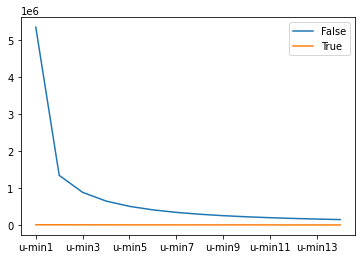

In [365]:
unique_fts.plot()
unique_fts["ratio"] = unique_fts[0]/unique_fts[1]
unique_fts

,False,True,ratio
min1,14555282,195647,74.39563
min2,10543617,195064,54.05209
min3,9621386,194145,49.55773
min4,8915801,193005,46.19466
min5,8341503,191743,43.50356
min6,7864363,190368,41.31137
min7,7456873,188790,39.49824
min8,7102974,187180,37.94729
min9,6791862,185572,36.59961
min10,6518190,183898,35.44459


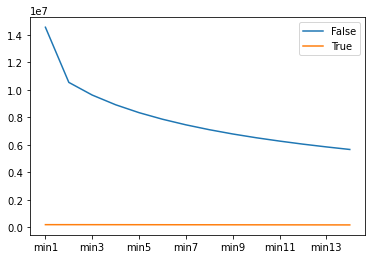

In [366]:
fts.plot()
fts["ratio"] = fts[0]/fts[1]
fts

In [367]:
target_visit = visit_freq[(visit_freq>=5)]
target_raw = stage1_raw[stage1_raw["mcvisid"].isin(target_visit.index)]

In [368]:
X = target_raw.sort_values(by=["date","hour"]).groupby("mcvisid").progress_apply(lambda x: "$".join(x["clean_PageURL"]))
y = target_raw.groupby("mcvisid")["label"].sum()>0

100%|████████████████████████████████| 511321/511321 [00:19<00:00, 26623.79it/s]


In [369]:
# target_pageurls = target_raw[["PageURL", "clean_PageURL"]].drop_duplicates()

In [370]:
data = pd.concat([X, y], axis=1)
data.columns = ["features", "label"]

### increase threshold
# data = data.loc[target_visit.index]
# print("reduce rows:", X.shape[0] - data.shape[0], "from ", X.shape[0], "keep rows: ", data.shape[0])

In [371]:
# data["features"].drop_duplicates()

In [372]:
# aa = data.groupby("features", group_keys=False).size().sort_values() # 检查是否有 同样数据 但是不同的 label 的数据
# aa.to_frame().tail(40).style

### Data split + TFIDF
<!-- 
# ## outdated
# data = stage1_raw.groupby("SessionVisitorId").apply(lambda x: processing_stage1(x, target_method=1, feature_method="bow"))
# data["submitted_form"].value_counts()

# def tfidf_transform(dtm, idf=None):
#     N = dtm.shape[0] # number of document
#     tf = (dtm/(dtm.sum(axis=1).reshape(-1,1)))

#     if idf is None:
#         idf = np.log(1 + N/(dtm.astype(bool).sum(axis=0)))
        
#     tfidf = tf * idf
#     return tfidf, idf
# v = DictVectorizer(sparse=False)
# X_train_dtm = v.fit_transform(X_train)
# X_test_dtm = v.transform(X_test)
# X_train_arr, idf = tfidf_transform(X_train_dtm)
# X_test_arr, _ = tfidf_transform(X_test_dtm, idf) -->

In [373]:
samples_checking = data[data["features"].transform(len)<500]
seeds= 10
samples_30 = samples_checking.assign(features_seq = samples_checking["features"].transform(lambda x: x.split("$"))).sample(30, random_state=seeds)
samples_30[["features_seq", "label"]].style

,features_seq,label
mcvisid,,
33157002874268034653922816459310381195,"['https://www.rockwellautomation.com/en-us', 'https://www.rockwellautomation.com/capabilities/sustainable-solutions/sustainability-roadmap', 'https://www.rockwellautomation.com/search', 'https://www.rockwellautomation.com/company/events/webinars/create-a-modern-maintenance-program-with-fiix', 'https://www.rockwellautomation.com/company/news/blogs/enabling-the-power-of-the-gigafactory', 'https://www.rockwellautomation.com/company/events/in-person-events/win-eurasia']",False
04058247754941867581885526478808471845,"['https://www.rockwellautomation.com/products/hardware/allen-bradley', 'https://www.rockwellautomation.com/lang-selection', 'https://www.rockwellautomation.com/en-us', 'https://www.rockwellautomation.com/lang-selection', 'https://www.rockwellautomation.com/search', 'https://www.rockwellautomation.com/products/hardware/allen-bradley/drives/drive-software']",False
29385111926510844802259227538688413593,"['https://www.rockwellautomation.com/company/about-us', 'https://www.rockwellautomation.com/products/software/factorytalk', 'https://www.rockwellautomation.com/products/hardware/allen-bradley/programmable-controllers/micro-controllers/micrologix-family/micrologix-1100-controllers', 'https://www.rockwellautomation.com/products/details.1766-L32BXB', 'https://www.rockwellautomation.com/products/hardware/allen-bradley/i-o/chassis-based-i-o/1762-micrologix-expansion-i-o']",False
73194307753914001230130280539437184516,"['https://www.rockwellautomation.com/en-us', 'https://www.rockwellautomation.com/en-us', 'https://www.rockwellautomation.com/en-us', 'https://www.rockwellautomation.com/en-us', 'https://www.rockwellautomation.com/en-us', 'https://www.rockwellautomation.com/en-us', 'https://www.rockwellautomation.com/en-us', 'https://www.rockwellautomation.com/en-us', 'https://www.rockwellautomation.com/en-us', 'https://www.rockwellautomation.com/en-us', 'https://www.rockwellautomation.com/en-us', 'https://www.rockwellautomation.com/en-us']",False
15127193125604689200902995775705702364,"['https://www.rockwellautomation.com/products/hardware/allen-bradley', 'https://www.rockwellautomation.com/search', 'https://www.rockwellautomation.com/products/hardware/allen-bradley/motor-control/soft-starters--low-voltage/smc-3-smart-motor-controller', 'https://www.rockwellautomation.com/products/details.150-SC3NBD', 'https://www.rockwellautomation.com/products/details.150-C317NBR']",False
11801933283959235961653509154048774017,"['https://www.rockwellautomation.com/search', 'https://www.rockwellautomation.com/search', 'https://www.rockwellautomation.com/search', 'https://www.rockwellautomation.com/search', 'https://www.rockwellautomation.com/search', 'https://www.rockwellautomation.com/search', 'https://www.rockwellautomation.com/lang-selection', 'https://www.rockwellautomation.com/search']",False
17674901021446132983256913034148126541,"['https://www.rockwellautomation.com/company/about-us', 'https://www.rockwellautomation.com/company', 'https://www.rockwellautomation.com/company/about-us/our-history', 'https://www.rockwellautomation.com/industries', 'https://www.rockwellautomation.com/company', 'https://www.rockwellautomation.com/company/about-us/our-community']",False
41899077931156909800531878527066634833,"['https://www.rockwellautomation.com/en-us', 'https://www.rockwellautomation.com/sales', 'https://www.rockwellautomation.com/sales', 'https://www.rockwellautomation.com/products/hardware/allen-bradley', 'https://www.rockwellautomation.com/company/news/press-releases/celebrating50yearsint-20190523-1359', 'https://www.rockwellautomation.com/company/news/blogs/fifty-not-out--and-just-getting-started-']",False
48388540400854098610564508697378055730,"['https://www.rockwellautomation.com/capabilities/industrial-automation-control/design-and-configuration-software', 'https://www.rockwellautomation.com/support', 'https://www.rockwellautomation.com/products', 'https://www.rockwell

In [374]:
print("pos vs neg in training set:",  Counter(data["label"]))
X_train, X_test, y_train, y_test = train_test_split(data["features"], data["label"], test_size=TEST_SIZE, stratify=data["label"].values, random_state=SEED)
print("training sample label proportion:", Counter(y_train))
print("testing sample label proportion:", Counter(y_test))

## down-sampling/up-sampling
data_train = pd.concat([X_train, y_train], axis=1)
# pos_size = y_train.sum()
# data_train = data_train.groupby('label', group_keys=False).apply(lambda x: x.sample(pos_size, replace=False))
neg_size = (~y_train).sum()
data_train = data_train.groupby('label', group_keys=False).apply(lambda x: x.sample(neg_size, replace=True))
X_train = data_train["features"]
y_train = data_train["label"]
print("after up/down-sampling, testing sample label proportion:", Counter(y_train))

pos vs neg in training set: Counter({False: 506195, True: 5126})
training sample label proportion: Counter({False: 404955, True: 4101})
testing sample label proportion: Counter({False: 101240, True: 1025})
after up/down-sampling, testing sample label proportion: Counter({False: 404955, True: 404955})


In [375]:
MIN_DF = 50
MAX_DF = 0.95
vectorizer = TfidfVectorizer(token_pattern=SEP_TOKEN_PATTERN, binary=False, max_df=MAX_DF, min_df=MIN_DF,dtype=np.float64)

X_train_arr = vectorizer.fit_transform(X_train)
X_test_arr = vectorizer.transform(X_test)
print(f"feature dimension {len(vectorizer.get_feature_names())} with min_df = {MIN_DF} max_df = {MAX_DF}")

feature dimension 8307 with min_df = 50 max_df = 0.95


In [376]:
# vectorizer.get_feature_names() # others = assign zero

### Models

#### dimension reduction
- for improve prediction accuracy only, not assigning weight

In [377]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib import colors

In [378]:
# pca = TruncatedSVD(n_components=3)
# pca_result = pca.fit_transform(X_train_arr)
# vis = pd.DataFrame()
# vis['pca-one'] = pca_result[:,0]
# vis['pca-two'] = pca_result[:,1] 
# vis['pca-three'] = pca_result[:,2]
# vis["y"]= y_train
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [379]:
# ax = plt.figure(figsize=(16,10)).gca(projection='3d')
# ax.scatter(
#     xs=vis["pca-one"], 
#     ys=vis["pca-two"], 
#     zs=vis["pca-three"], 
#     c=vis["y"], 
#     cmap='tab10'
# )
# ax.set_xlabel('pca-one')
# ax.set_ylabel('pca-two')
# ax.set_zlabel('pca-three')
# plt.show()

In [133]:
# data_subset = data.sample(50000, random_state=22 )
# tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=250)
# tsne_results = tsne.fit_transform(vectorizer.transform(data_subset["features"]))

# data_subset['tsne-3d-one'] = tsne_results[:,0]
# data_subset['tsne-3d-two'] = tsne_results[:,1]
# data_subset['tsne-3d-three'] = tsne_results[:,2]

# ax = plt.figure(figsize=(16,10)).gca(projection='3d')
# ax.scatter(
#     xs=data_subset['tsne-3d-one'],
#     ys=data_subset['tsne-3d-two'],
#     zs=data_subset['tsne-3d-three'],
#     c=data_subset["label"], 
#     cmap=colors.ListedColormap(['blue', 'red'])
# )
# ax.set_xlabel('tsne-3d-one')
# ax.set_ylabel('tsne-3d-two')
# ax.set_zlabel('tsne-3d-three')
# plt.show()
# data_subset["label"].value_counts()

#### LR

              precision    recall  f1-score   support

       False       1.00      0.84      0.91    101240
        True       0.04      0.59      0.07      1025

    accuracy                           0.84    102265
   macro avg       0.52      0.72      0.49    102265
weighted avg       0.99      0.84      0.90    102265



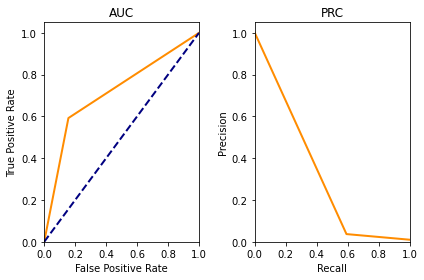

AUC: 71.79%, PRC: 31.66%


In [381]:
model = LogisticRegression()
model.fit(X_train_arr, y_train)
# model.coef_
y_pred = model.predict(X_test_arr)
evaluate_metrics(y_test, y_pred, show_plots = True)

#### svm (x)
- no weight but only predict prob 

              precision    recall  f1-score   support

       False       0.99      0.86      0.92    101240
        True       0.03      0.49      0.06      1025

    accuracy                           0.86    102265
   macro avg       0.51      0.68      0.49    102265
weighted avg       0.98      0.86      0.91    102265



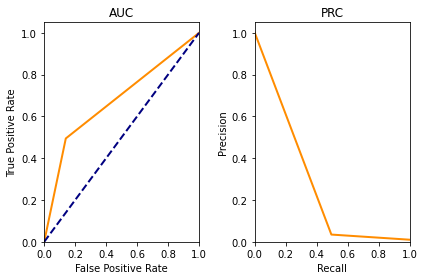

AUC: 67.76%, PRC: 26.72%


In [382]:
svm_clf = svm.LinearSVC(C=1)
svm_clf.fit(X_train_arr, y_train)
y_pred = svm_clf.predict(X_test_arr)
evaluate_metrics(y_test, y_pred, show_plots = True)

#### naive bayes
- $\theta_{yi}$ is the probability $P(x_i \mid y)$ of feature i appearing in a sample belonging to class y.

              precision    recall  f1-score   support

       False       0.99      0.77      0.87    101240
        True       0.03      0.59      0.05      1025

    accuracy                           0.77    102265
   macro avg       0.51      0.68      0.46    102265
weighted avg       0.98      0.77      0.86    102265



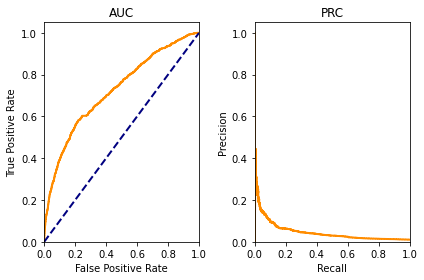

AUC: 72.44%, PRC: 4.60%


In [383]:
clf = MultinomialNB().fit(X_train_arr, y_train)
asset_prob = np.exp(clf.feature_log_prob_[0])
# clf.feature_log_prob_[0]
y_pred = (clf.predict_proba(X_test_arr))[:, 1]
evaluate_metrics(y_test, y_pred, show_plots = True)

### <font color=red>cross validation</font>
<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="300"/>

In [384]:
scores = cross_validate(clf, X_train_arr, y_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores["test_score"].mean(), scores["test_score"].std()))

0.79 accuracy with a standard deviation of 0.00


### Assign Weight
- conditional prob

In [385]:
# log p(w|c=1) + log p(w|c=0)
asset_prob = np.exp(clf.feature_log_prob_[0])

In [386]:
weights = pd.DataFrame([vectorizer.get_feature_names(), asset_prob.tolist()]).T
weights.columns = ["asset", "weight"]
# weights.sort_values(by="weight", ascending=False).style
# weights = weights[weights["weight"]>weights["weight"].mean()]

## Correlation

In [387]:
# mat2 = pd.DataFrame(np.hstack([y_train.reshape(-1,1), X_train_arr.toarray()]), columns=["y"]+vectorizer.get_feature_names())
# corr = mat2.corr().iloc[1:, 0:1].sort_values("y")
# corr.plot(kind="bar")
# corr

In [388]:
# corr.style.background_gradient(cmap='coolwarm', axis=None)

## Weight Rescaling
lowest level is 1, decide which one has higher importance score. start with 1

In [389]:
x = weights["weight"].astype(float)
x.describe()

count   8307.00000
mean       0.00012
std        0.00096
min        0.00000
25%        0.00001
50%        0.00002
75%        0.00005
max        0.05279
Name: weight, dtype: float64

### Three levels (prefer)

In [390]:
num_levels = 3
color_opts = ['lightskyblue', 'turquoise', 'orange', 'blue', 'red']

In [391]:
xx = pd.concat([weights["asset"], x, pd.cut(x, num_levels)], axis=1)
xx.columns = ["asset", "weight", "bins"]
xx["bins"] = xx["bins"].map(lambda x: f"[{str(x.left)}, {str(x.right)}]")
bin_dict = sorted(xx["bins"].unique().tolist())

colors = dict(zip(bin_dict, color_opts[0:num_levels]))
labels = dict(zip(bin_dict, range(1, len(bin_dict)+1)))

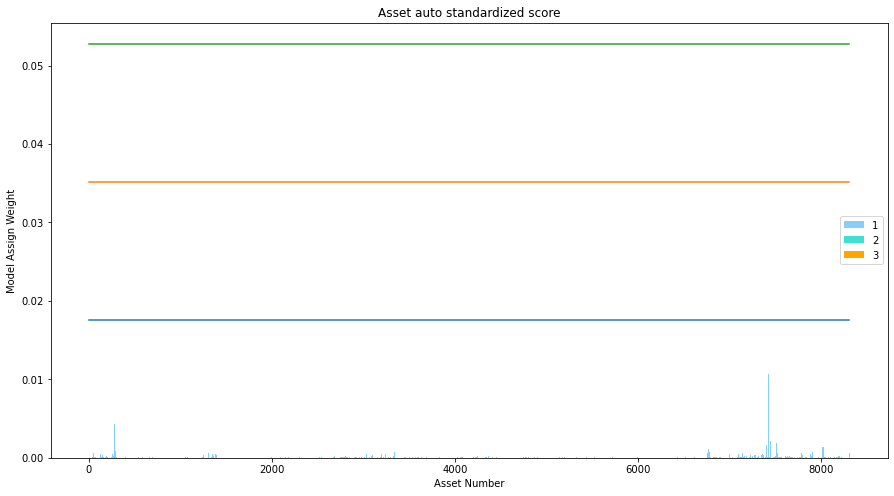

In [392]:
xx["color"] = xx["bins"].apply(lambda x: colors[x] if x in colors else "NA")
xx["auto_score"] = xx["bins"].apply(lambda x: labels[x] if x in colors else "NA")

plt.figure(figsize=(15,8))

for idx, item in xx.groupby("bins"):
    if item.shape[0] ==0:
        continue
    plt.bar(x=item.index, height = item["weight"], color=item["color"], label=item["auto_score"].iloc[0])

for pair in bin_dict:
    upper_line = eval(pair)[1]
    plt.plot([0, xx.index[-1]],[upper_line,upper_line])

    
plt.xlabel("Asset Number")
plt.ylabel("Model Assign Weight")
plt.title("Asset auto standardized score")
plt.legend()
plt.show()

In [393]:
xx[["asset", "auto_score"]]

,asset,auto_score
0,https://www.rockwellautomation.com,1
1,https://www.rockwellautomation.com/%20e300,1
2,https://www.rockwellautomation.com//404,1
3,https://www.rockwellautomation.com/404,1
4,https://www.rockwellautomation.com/answers/det...,1
...,...,...
8302,https://www.rockwellautomation.com/webappng/si...,1
8303,https://www.rockwellautomation.com/webex,1
8304,https://www.rockwellautomation.com/webex.com,1
8305,https://www.rockwellautomation.com/whitepaper-...,1


In [394]:
xx[xx["auto_score"]>1]

,asset,weight,bins,color,auto_score
1301,https://www.rockwellautomation.com/en-us,0.04224,"[0.0352, 0.0528]",orange,3
6752,https://www.rockwellautomation.com/products/ha...,0.02844,"[0.0176, 0.0352]",turquoise,2
7992,https://www.rockwellautomation.com/search,0.05279,"[0.0352, 0.0528]",orange,3


### min-max Normalization

In [ ]:
x = weights["weight"].astype(float) 
x = (x-x.min())/(x.max()-x.min()) * 5
x.plot(kind="bar")

### z-score Standardization

In [ ]:
x = weights["weight"].astype(float) 
x = 1 + ((x-x.mean())/x.std())
x.plot(kind="bar")

## Others 

# Store model and prediction

In [ ]:
import pickle

In [ ]:
with open('model_v1.pkl','wb') as f:
    pickle.dump(clf, f)

In [ ]:
# load
with open('model_v1.pkl', 'rb') as f:
    clf2 = pickle.load(f)

## Prediction/Test with the latest month data

# Post to AEM

In [ ]:
# np.exp(clf2.feature_log_prob_[0])

# Checking